# 03 - Forecasting baseline

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import energy_forecast
from energy_forecast.utils import repo_root
from energy_forecast.preprocessing import load_and_set_types
import pandas as pd
from pandas import DataFrame
from pathlib import Path

from sktime.transformations.series.detrend import STLTransformer


In [8]:
REPO_ROOT = Path(repo_root())
DATA_PROCESSED = REPO_ROOT / 'data' / 'processed'

Y_TRAIN_PATH = DATA_PROCESSED / 'y_train.csv'
Y_TEST_PATH = DATA_PROCESSED / 'y_test.csv'
X_TRAIN_PATH = DATA_PROCESSED / 'x_train.csv'
X_TEST_PATH = DATA_PROCESSED / 'x_test.csv'

In [13]:
y_train = load_and_set_types(Y_TRAIN_PATH)
x_train = load_and_set_types(X_TRAIN_PATH)


y_train.shape

2022-10-18 23:57:11.016 | DEBUG    | energy_forecast.preprocessing:load_and_set_types:8 - Loading csv and setting types
2022-10-18 23:57:11.025 | DEBUG    | energy_forecast.preprocessing:load_and_set_types:8 - Loading csv and setting types


(193, 1)

# Univariate forecasting

In [16]:
stl = STLTransformer(sp=12)
out = stl.fit_transform(y_train)

In [19]:
type(out)

pandas.core.frame.DataFrame

## Timeseries Plots
Following along with https://otexts.com/fpp3/lag-plots.html

- Timeplot (pandas plot or matplotlib)
- Seasonal plot (seaborn lineplot with 'hue')
- Seasonal subseries monthly plot (statsmodels monthly_plot)


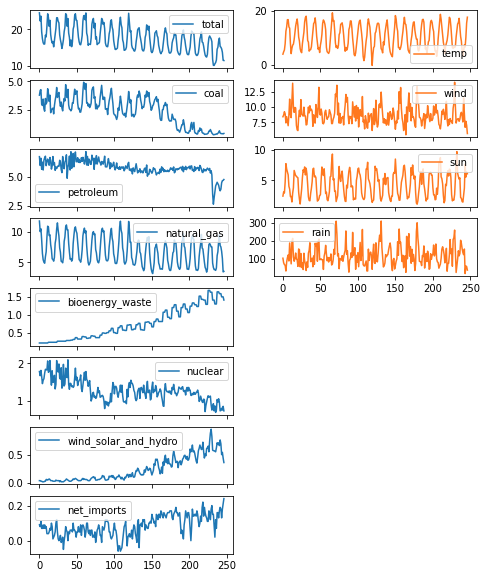

In [ ]:
# Time plot grid
cols_energy = ['total', 'coal', 'petroleum', 'natural_gas', 
               'bioenergy_waste', 'nuclear', 'wind_solar_and_hydro', 'net_imports']
cols_weather = ['temp','wind','sun','rain']

# Easiest to visualise the nan values
fig = plt.figure()
fig.set_size_inches(8,10)
for i, col in enumerate(cols_energy):
    sharex = ax if i>0 else None
    ax = fig.add_subplot(len(cols_energy),2,2*i+1, sharex=sharex)
    df.plot(y=col, ax=ax)

for i, col in enumerate(cols_weather):
    sharex = ax if i>0 else None
    ax = fig.add_subplot(len(cols_energy),2,2*i+2, sharex=sharex)
    df.plot(y=col, ax=ax, style='#ff781f')

This plot gives a good intuition of the general patterns. Looks like:
- Petroleum had a massive downward spike in the  last few years. This could be due to the pandemic's impact on road travel etc.
- Bioenergy and wind/solar etc are all on a steady rising trend, still small in proportion to total energy use though.
- There are some strong seasonal patterns in certain energy sources and,  as expected, in weather patterns.
- Coal especially has seen a sharp decline in use over the recent decade.


Text(0.5, 1.0, 'Total energy use vs Date')

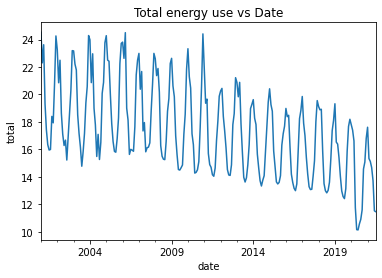

In [ ]:
# Time plot for total energy use
fig = plt.figure()
ax = fig.add_subplot()
df.set_index('date').total.plot(ax=ax)
ax.set_ylabel('total');
ax.set_title('Total energy use vs Date')

Zooming into just the total energy use **(which we will mostly be analysing and trying to forecast)**
- Trend is decreasing over time, not quite linearly.
- Looks like there is a strong yearly seasonality
- The amplitude of the seasonality component looks quite consistent.
- A reasonably sharp dip in mid-2020.  Could this coincide with Covid-19 related effects on energy use?

### Seasonal plot

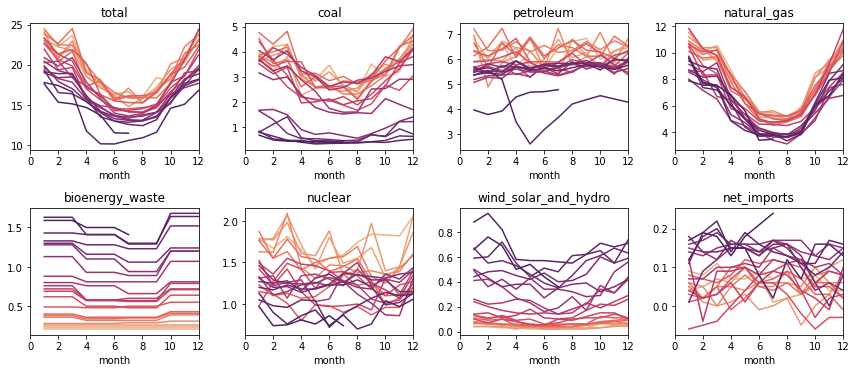

In [ ]:
# Add year and month cols
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month

# Seasonal plot for energy consumption
fig = plt.figure()
fig.set_size_inches(12,10)
for i, col in enumerate(['total', 'coal', 'petroleum', 'natural_gas', 
                         'bioenergy_waste', 'nuclear', 'wind_solar_and_hydro', 
                         'net_imports']):
    share = ax if i>0 else None
    ax = fig.add_subplot(4,4,i+1, sharex=share)
    ax.set_xlim([0,12])
    ax.set_xticks(list(range(0,13,2)))
    sns.lineplot(data=df, x='month', y=col, hue='year', ax=ax, palette='flare' , legend=None)
    ax.set_ylabel('')
    ax.set_title(col)
fig.tight_layout()

This grid of plots shows each season's data overlaid on an annual period.  Gives a quick intuition of the seasonal trends in the data
- Coal, natural gas all have quite a strong, similar seasonality effect.
- The seasonality in total energy use must be mostly due to the natural gas and coal seasonality.  These are probably driven by heating demand in winter months?
- Nuclear, petroleum etc are quite non-seasonal.

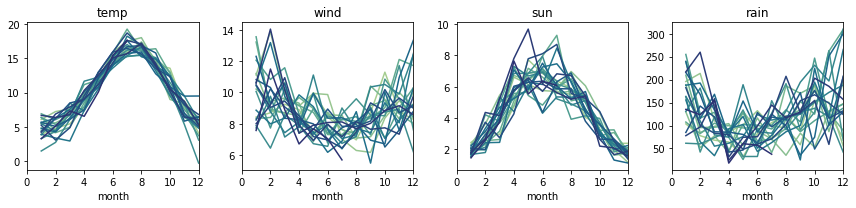

In [ ]:
# Plot seasonal for weather
fig = plt.figure()
fig.set_size_inches(12,3)
for i, col in enumerate(['temp','wind','sun','rain']):
    sharex = ax if i>0 else None
    ax = fig.add_subplot(1,4,i+1, sharex=sharex)
    sns.lineplot(data=df, x='month', y=col, hue='year', ax=ax, palette='crest' , legend=None)
    ax.set_xlim([0,12])
    ax.set_xticks(list(range(0,13,2)))
    ax.set_ylabel('')
    ax.set_title(col)
fig.tight_layout()

Likewise this plot grid shows the same thing, but for the weather data.
- Strong seasonality for Temps and daily Sunlight. Is inverse w.r.t. the total energy use seasonality we saw earlier.  Strong indication that UK energy use is driven by weather, and therefore heating demands.
- Wind speeds and rainfall have the opposite seasonality to Temp and daily Sunlight.
- These 4 charts basically confirm the expected seasonal weather patterns we see in this country.

### Seasonal subseries plot

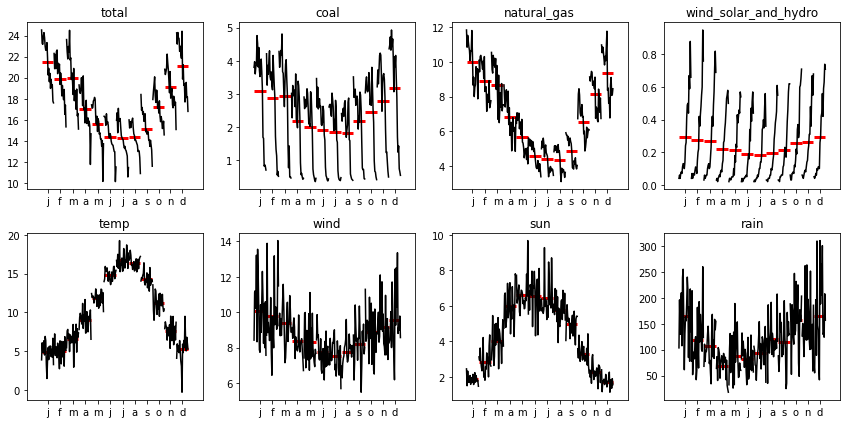

In [ ]:
# Plot seasonal subseries plot for a few features
fig = plt.figure()
fig.set_size_inches(12,6)
for i, col in enumerate(['total', 'coal', 'natural_gas', 'wind_solar_and_hydro', 
                         'temp', 'wind', 'sun', 'rain']):
    sharex = ax if i>0 else None
    ax = fig.add_subplot(2,4,i+1, sharex=sharex)
    month_plot(df.set_index('date')[col], ax=ax);
    # sns.lineplot(data=df, x='month', y=col, hue='year', ax=ax, palette='crest' , legend=None)
    # ax.set_xlim([0,12])
    # ax.set_xticks(list(range(0,13,2)))
    # ax.set_ylabel('')
    ax.set_title(col)
fig.tight_layout()

This seasonal subseries plot puts each month's data togather, so we can see the annual trend at each point in the year (seasonal period). by the shape of each line segment, rather than the colours on the previous seasonal grid plots.  

The mean value for each month is also plotted, so we can see the seasonal variation a bit more clearly.
- All columns shown have quite clear seasonality
- Total energy is highly seasonal (just like gas and coal use), but the decreasing trend is quite sharp in recent years and is quite consistent across all months.  We could conclude that the decreasing trend is more driven by decreases in other less seasonal energy sources like petroleum etc.
- We can see a strong rise in renewable energy use, though still small in proportion to other sources.

### Scatter matrix

In [ ]:
# Scatter plot

# Doesn't really work yet we've not got any explanatory features really yet
# Might try once I have weather data included

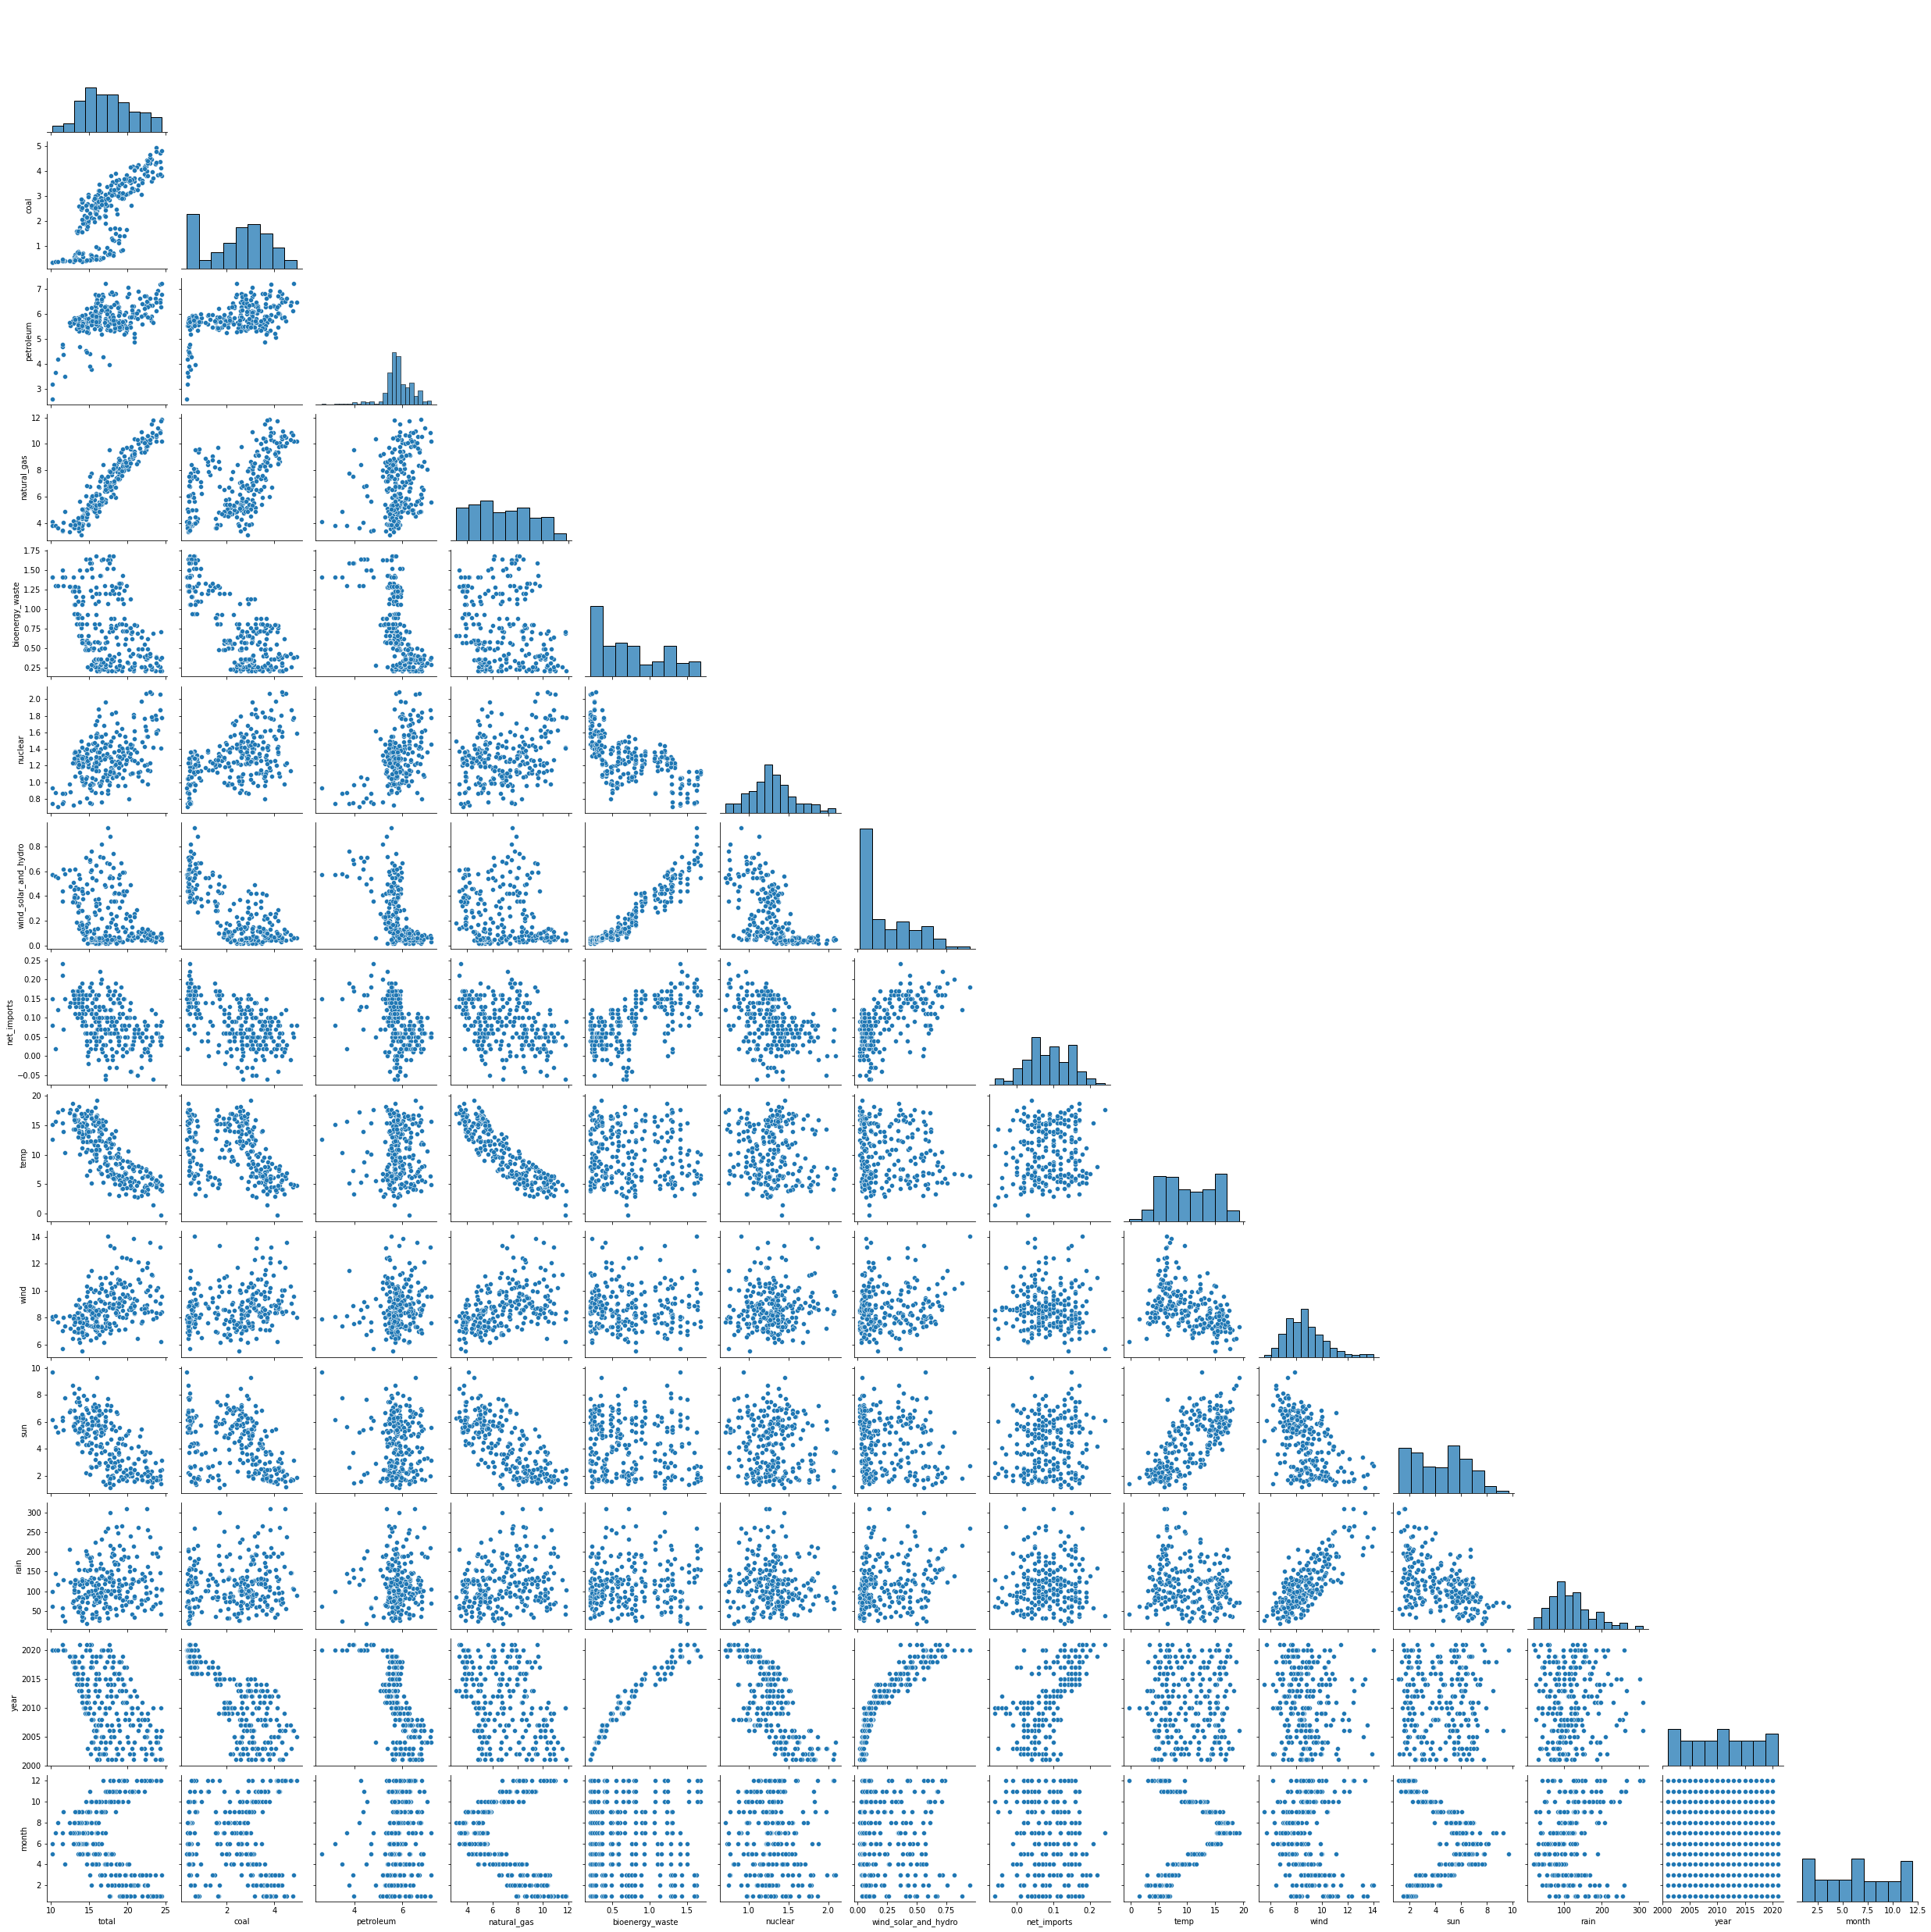

In [ ]:
# Scatter matrix
sns.pairplot(df.set_index('date'), corner=True);

### Lag plot (TODO)

In [ ]:
# Lag plot
# TODO

### Autocorrelation plot

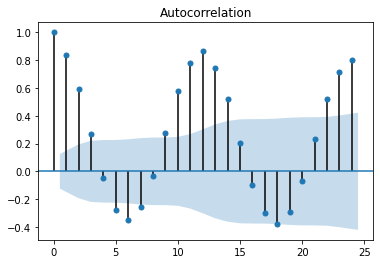

In [ ]:
# ACF plot
plot_acf(df.total);

### Correlation matrix (pearson)

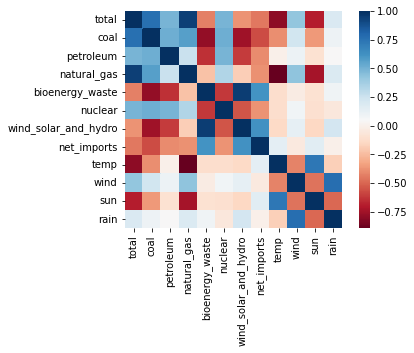

In [ ]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, square=True, cmap='RdBu');

These are Pearson correlation coefficients so don't tell us anything about any non-linear correlations, but give a good starting point
- **Natural gas consumption** has strong negative correlation with **temperature** and **sunlight**.  *This makes sense as natural gas could be mainly used for domestic heating, so could in high use during colder months.*
- **Total energy** is highly correlated with **natural gas**
- **Wind, Solar & Hydro** consumption seems to correlate:
  - Slightly positively with **wind speeds** and **rainfall**
  - Slightly negative with **sunlight** and **temperature**.  *Might indicate that solar power is a fairly small contributor to this category, since I would expect solar power to behave opposite to this*
- **Nuclear** is fairly uncorrelated with any weather parameters.  *This makes sense as nuclear is a fairly constant non-varying part of the energy supply*

# Forecasting

## Baseline models

### Mean

### Naive model

## Model evaluation

### Residuals

### Cross validation
Walk forward validation